# Machine Learning Fundamentals - Lecture 05

This is the Jupyter notebook for Lecture 05 of the Machine Learning Fundamentals
course.

In [83]:
# Import the required libraries using the commonly use short names (pd, sns, ...)
import numpy as np
import pandas as pd

# This allows us to specify Python types in our functions, which then helps in
# auto-completing our code when we use those functions
from numpy.typing import NDArray

# The Path object from pathlib allows us to easily build paths in an
# OS-independent fashion
from pathlib import Path

# This will help us cycle through the predefined color list (colormap) of a
# matplotlib plot
from itertools import cycle

# Load the required scikit-learn classes and functions
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC

# Load matplotlib
import matplotlib.pyplot as plt

# Get the colors array from the current matplotlib colormap
# We'll cycle through these predefined colors in each plot to keep consistency
# and so that our plots don't look horrible with colors chosen by us
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [84]:
# Load the dataset (note the use of the Path object)
df = pd.read_csv(Path("Pokemon.csv"))

# It's not good practice to have column names with spaces and other non-standard
# characters, so let's fix this by renaming the columns to standard names
df.rename(columns={
    "Type 1" : "Type1",
    "Type 2" : "Type2",
    "Sp. Atk" : "SpAtk",
    "Sp. Def" : "SpDef",
}, inplace=True)

# Replace missing values in the "Type2" column with the string "None"
df["Type2"] = df["Type2"].fillna("None")

# Since primary and secondary types are essentially categories (and not just
# strings / objects), we can convert these columns to the category type
df["Type1"] = df["Type1"].astype("category")
df["Type2"] = df["Type2"].astype("category")

## Our own 1D linear regressor

In [85]:
# Let's try this out by predicting total from a single feature: Attack
X1d = df[["Attack"]].to_numpy()
y1d = df[["Total"]].to_numpy()

# Let's split our data into training (80%) and test (20%) sets
# Change the random_state parameter do split data in different ways
X1d_train, X1d_test, y1d_train, y1d_test = train_test_split(X1d, y1d, test_size=0.2, random_state=42)

In [86]:
# Here's our 1D linear regression class
class LinReg1D:

    # Method for training the model, i.e., performing the fit()
    def fit(self, x_train: NDArray, y_train: NDArray):

        # Make sure our x and y are 1D arrays
        x_train = x_train.ravel()
        y_train = y_train.ravel()

        # Get the mean of x and y
        mx = x_train.mean()
        my = y_train.mean()

        # Apply the formula for m
        m = np.sum((x_train - mx) * (y_train - my)) / np.sum((x_train - mx) ** 2)

        # Apply the formula for b
        b = my - m * mx

        # Keep m and b within this object
        self.m = m
        self.b = b

    # Method for performing the prediction
    def predict(self, x_test: NDArray):

        # Simply apply the line equation
        return self.m * x_test.ravel() + self.b

In [87]:
# Let's try out our own 1D linear regression implementation
lr1d = LinReg1D()

# Follow the typical steps: fit (train) and predict (infer)
lr1d.fit(X1d_train, y1d_train)
y1d_pred = lr1d.predict(X1d_test)

# Check out the R^2 score for out 1D linear regressor
lr1d_r2 = r2_score(y1d_test, y1d_pred)

print(f"R² score for our linear regressor: {lr1d_r2}")

R² score for our linear regressor: 0.5680252046719954


In [88]:
# Test scikit-learn's linear regressor
lrskl = LinearRegression()

# Follow the typical steps: fit (train) and predict (infer)
lrskl.fit(X1d_train, y1d_train)
y_skl_pred = lrskl.predict(X1d_test)

# Check out the R^2 score for scikit-learn's linear regressor
lrskl_r2 = r2_score(y1d_test, y_skl_pred)

print(f"R² score for Scikit-learn's linear regressor: {lrskl_r2}")

R² score for Scikit-learn's linear regressor: 0.5680252046719954


Looking at both $R^2$ scores, we can observe that we obtain the exact same
result.

Let's draw a plot comparing the two predictions:

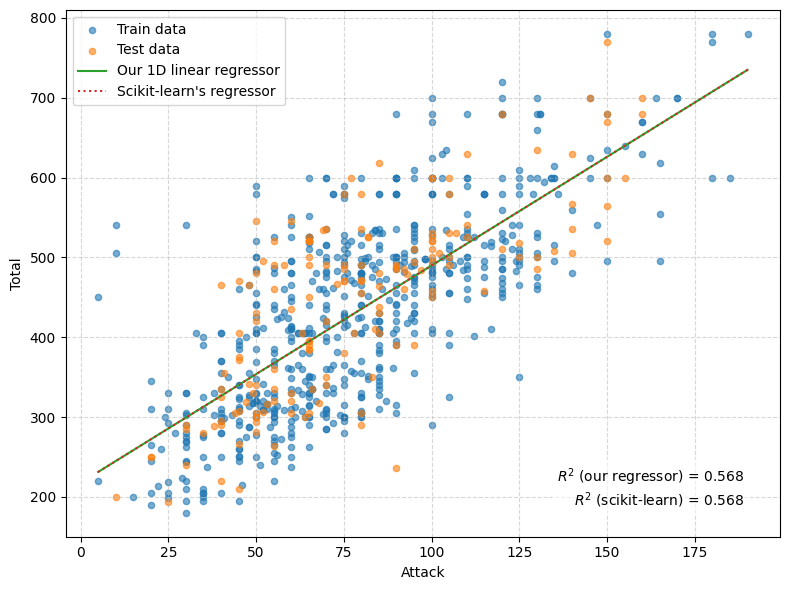

In [89]:
# Create a new color cycler
cycler = cycle(colors)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# First, plot the training data
ax.scatter(X1d_train, y1d_train, s=20, color=next(cycler), alpha=0.6, label="Train data")

# Then the test data
ax.scatter(X1d_test.ravel(), y1d_test, s=20, color=next(cycler), alpha=0.6, label="Test data")

# Create test grid for plotting the regression lines
X_pred_plot = np.linspace(X1d.min(), X1d.max(), 500).reshape(-1, 1)
y_pred_plot_rl1d = lr1d.predict(X_pred_plot)    # Ours
y_pred_plot_rlskl = lrskl.predict(X_pred_plot)  # Scikit-learn's

# Now let's plot the regression lines for each regressor
ax.plot(X_pred_plot, y_pred_plot_rl1d, color=next(cycler), linewidth=1.5, label="Our 1D linear regressor")
ax.plot(X_pred_plot, y_pred_plot_rl1d, color=next(cycler), linewidth=1.5, linestyle="dotted", label="Scikit-learn's regressor")

# Labels, legend, and background grid
ax.set_xlabel("Attack")
ax.set_ylabel("Total")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

# Present the R^2's directly in the figure
ax.text(
    0.95, 0.05, # (x, y) in axes fraction coordinates
    f"$R^2$ (our regressor) = {lr1d_r2:.3f}\n$R^2$ (scikit-learn) = {lrskl_r2:.3f}",
    transform=ax.transAxes, # interpret (x, y) as fraction of Axes
    ha="right", va="bottom", # align text to right bottom corner
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
)

fig.tight_layout()

## Implement a multi-dimensional regressor

In [90]:
# Let's use all features except Speed, otherwise we'll get a perfect regression
# (since Total is literally the sum of all features)
features = ["HP", "Attack", "Defense", "SpAtk", "SpDef" ] #, "Speed"]

# Get only the specified features
X = df[features].to_numpy()

# Our target values will the the "Total" column
y = df["Total"].to_numpy()

# Let's split our data into training (80%) and test (20%) sets
# Change the random_state parameter do split data in different ways
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
# Here's our multidimensional linear regression class (also works in 1D!)
class LinReg:

    # Method for training the model, i.e., performing the fit()
    def fit(self, X_train: NDArray, y_train: NDArray):

        # Add a first column of ones
        X = np.concat((np.ones((X_train.shape[0], 1)), X_train), axis=1)

        # Apply the general OLS formula to obtain the regression coefficients
        # and keep them in the object
        self.B = np.linalg.inv(X.T @ X) @ X.T @ y_train

    # Method for performing the prediction
    def predict(self, X_test: NDArray):

        # Add a first column of ones
        X = np.concat((np.ones((X_test.shape[0], 1)), X_test), axis=1)

        # Apply the line equation
        return X @ self.B

In [92]:
# Let's try out our own multidimensional linear regression implementation
lrnd = LinReg()

# Follow the typical steps: fit (train) and predict (infer)
lrnd.fit(X_train, y_train)
ynd_pred = lrnd.predict(X_test)

# Check out the R^2 score for out multidimensional linear regressor
lrnd_r2 = r2_score(y_test, ynd_pred)

print(f"R² score for our linear regressor: {lrnd_r2}")

R² score for our linear regressor: 0.9588834298188778


In [93]:
# Test scikit-learn's linear regressor
lrskl = LinearRegression()

# Follow the typical steps: fit (train) and predict (infer)
lrskl.fit(X_train, y_train)
yskl_pred = lrskl.predict(X_test)

# Check out the R^2 score for scikit-learn's linear regressor
lrskl_r2 = r2_score(y_test, yskl_pred)

print(f"R² score for Scikit-learn's linear regressor: {lrskl_r2}")

R² score for Scikit-learn's linear regressor: 0.9588834298188773


Looking at both $R^2$ scores, we can observe that we obtain the exact same
result.

Let's now test various regularized linear regressors (with their default
values), as well as polynomial linear regression, to check if $R^2$ increases.

In [94]:
# For Ridge, Lasso, and ElasticNet, we need to scale
ss = StandardScaler()

# Fit only on training data, then transform (scale) it
X_train_scaled = ss.fit_transform(X_train)

# Use the same transformation on test data
X_test_scaled = ss.transform(X_test)

In [95]:
# Reprint the R^2 score for OLS linear regression, for comparison
print(f"R² score for OLS linear regression: {lrskl_r2}")

# Let's start with Ridge linear regression
ridge = Ridge()

ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"R² score for Ridge regression: {ridge_r2}")

# Now Lasso
lasso = Lasso()

lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
lasso_r2 = r2_score(y_test, lasso_pred)

print(f"R² score for Lasso regression: {lasso_r2}")

# ElasticNet: combining Ridge and Lasso
enet = ElasticNet()

enet.fit(X_train_scaled, y_train)
enet_pred = enet.predict(X_test_scaled)
enet_r2 = r2_score(y_test, enet_pred)

print(f"R² score for Elastic Net: {enet_r2}")

# Now lets try out polynomial regression with different degrees: 2, 5, 10
# We'll use the pipeline approach. Note that polynomial features are obtained
# before scaling. Why? Here's a good explanation:
# When you create feature interactions, you’re generating values that are
# multiples and squares of themselves. By creating interactions between
# z-score sized values, you’ll get values a magnitude smaller than the original.
# The purpose of squaring values in PolynomialFeatures is to increase signal. To
# retain this signal, it’s better to generate the interactions first then
# standardize second.
# Source: https://samchaaa.medium.com/preprocessing-why-you-should-generate-polynomial-features-first-before-standardizing-892b4326a91d

# Degree = 2
poly2 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])

poly2.fit(X_train, y_train)
poly2_pred = poly2.predict(X_test)
poly2_r2 = r2_score(y_test, poly2_pred)

print(f"R² score for Poly2: {poly2_r2}")

# Degree = 5
poly5 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=5, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])

poly5.fit(X_train, y_train)
poly5_pred = poly5.predict(X_test)
poly5_r2 = r2_score(y_test, poly5_pred)

print(f"R² score for Poly5: {poly5_r2}")

# Degree = 10
poly10 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])

poly10.fit(X_train, y_train)
poly10_pred = poly10.predict(X_test)
poly10_r2 = r2_score(y_test, poly10_pred)

print(f"R² score for Poly10: {poly10_r2}")

R² score for OLS linear regression: 0.9588834298188773
R² score for Ridge regression: 0.958932799363037
R² score for Lasso regression: 0.9593019475945344
R² score for Elastic Net: 0.9342882171202535
R² score for Poly2: 0.9590600432457592
R² score for Poly5: -1.501253432675044
R² score for Poly10: -3608330.632475014


Lasso behaves better here, with an $R^2$ score of $0.9593$, followed by
polynomial linear regression with degree 2 with $R^2=0.9590$. Higher degree
polynomials are clearly detrimental, as they overfit the training data and are
unable to generalize for the test data.

## Polynomial intuition

In this final part, we'll plot the 1D regression with OLS linear regression and
compare it with several degrees of polynomial regression, so we get an intuition
on how it works. 

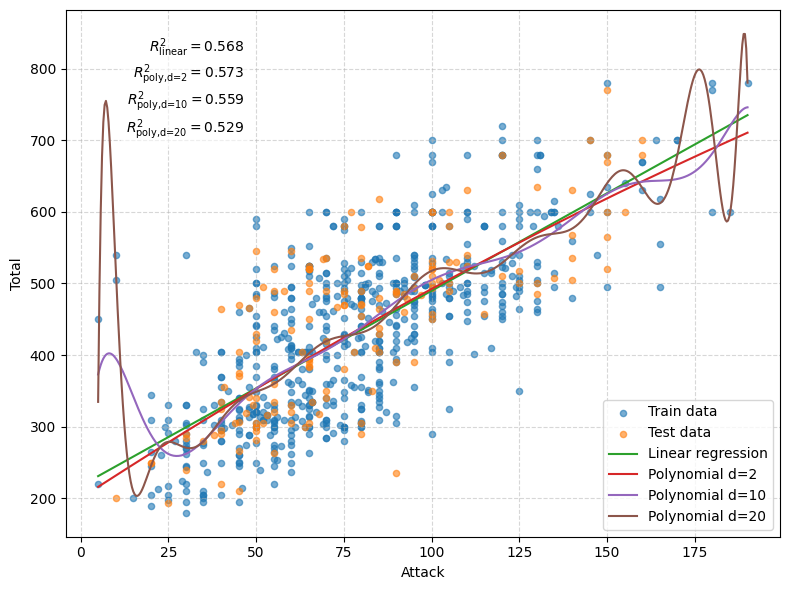

In [96]:
# Create a new color cycler
cycler = cycle(colors)

# A standard OLS linear regressor
lr = LinearRegression()

# Polynomial regressors with various degrees: 2, 10, 20
poly2 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])
poly10 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])
poly20 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=20, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])

# Train regressors
lr.fit(X1d_train, y1d_train)
poly2.fit(X1d_train, y1d_train)
poly10.fit(X1d_train, y1d_train)
poly20.fit(X1d_train, y1d_train)

# Get predictions on test data
y_pred_lr = lr.predict(X1d_test)
y_pred_p2 = poly2.predict(X1d_test)
y_pred_p10 = poly10.predict(X1d_test)
y_pred_p20 = poly20.predict(X1d_test)

# Obtain R²'s
r2_lr = r2_score(y1d_test, y_pred_lr)
r2_p2 = r2_score(y1d_test, y_pred_p2)
r2_p10 = r2_score(y1d_test, y_pred_p10)
r2_p20 = r2_score(y1d_test, y_pred_p20)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# First, plot the training data
ax.scatter(X1d_train, y1d_train, s=20, color=next(cycler), alpha=0.6, label="Train data")

# Then the test data
ax.scatter(X1d_test.ravel(), y1d_test, s=20, color=next(cycler), alpha=0.6, label="Test data")

# Create test grid for plotting the regression lines
X_pred_plot = np.linspace(X1d.min(), X1d.max(), 500).reshape(-1, 1)
y_pred_plot_lr = lr.predict(X_pred_plot)
y_pred_plot_p2 = poly2.predict(X_pred_plot)
y_pred_plot_p10 = poly10.predict(X_pred_plot)
y_pred_plot_p20 = poly20.predict(X_pred_plot)

# Now let's plot the regression lines for each regressor
ax.plot(X_pred_plot, y_pred_plot_lr, color=next(cycler), label="Linear regression")
ax.plot(X_pred_plot, y_pred_plot_p2, color=next(cycler), label="Polynomial d=2")
ax.plot(X_pred_plot, y_pred_plot_p10, color=next(cycler), label="Polynomial d=10")
ax.plot(X_pred_plot, y_pred_plot_p20, color=next(cycler), label="Polynomial d=20")

# Labels, legend, and background grid
ax.set_xlabel("Attack")
ax.set_ylabel("Total")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

# Present the R^2's directly in the figure
ax.text(
    0.25, 0.95, # (x, y) in axes fraction coordinates
    r"$R^2_{\text{linear}}=" + f"{r2_lr:.3f}" + "$\n" +
    r"$R^2_{\text{poly,d=2}}=" + f"{r2_p2:.3f}" + "$\n" +
    r"$R^2_{\text{poly,d=10}}=" + f"{r2_p10:.3f}" + "$\n" +
    r"$R^2_{\text{poly,d=20}}=" + f"{r2_p20:.3f}" + "$",
    transform=ax.transAxes, # interpret (x, y) as fraction of Axes
    ha="right", va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
)

fig.tight_layout()

As we can observe, for polynomial regression with degree 2, the $R^2$ score
improves a bit with respect to OLS linear regression. However, increasing the
degree can make the regression overfit the training data, and thus generalize
poorly to the test data. This can be observed in the lower values of $R^2$ for
degree 10 and 20, but not to the extent we saw in the multidimensional case.
Since the 1D case is much simpler, the overfit will never be as bad as in the
multidimensional case.

---
# NEW: Mini Project 5: Standard Logistic Regression and SVM Classifiers
---

## 2D Logistic Regression 

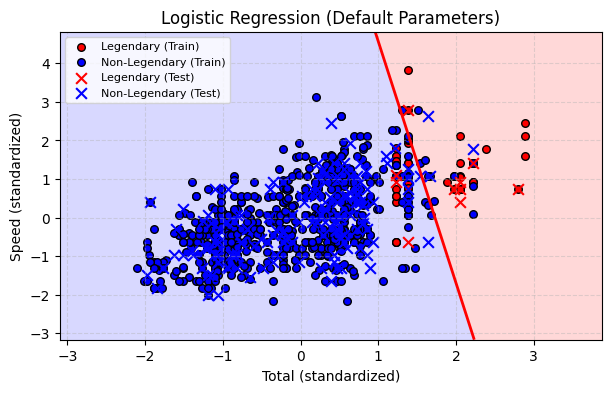

Accuracy (default parameters): 0.96250


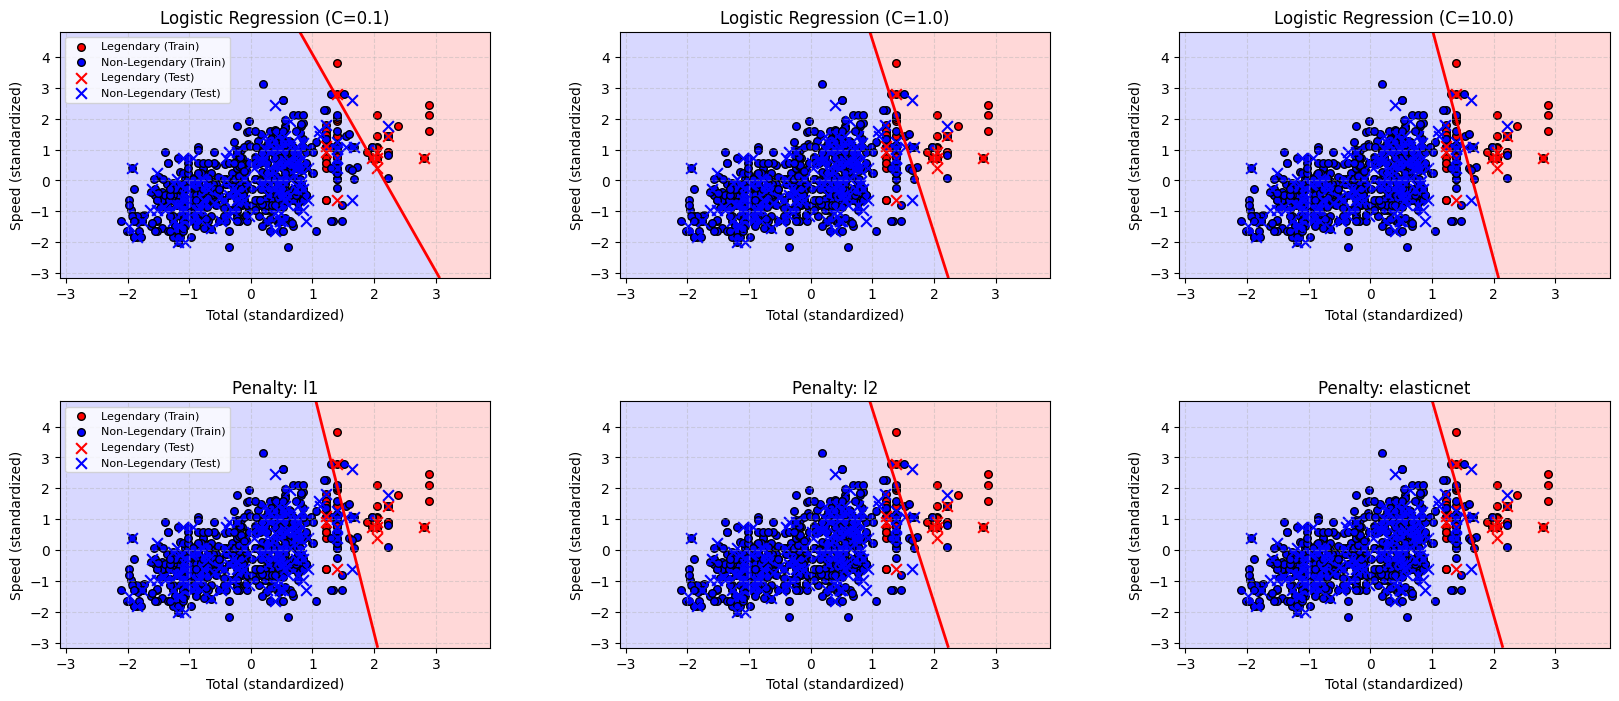


Accuracy for different C values:
   C  Accuracy
 0.1   0.96875
 1.0   0.96250
10.0   0.95625

Accuracy for different penalty types:
   Penalty  Accuracy
        l1   0.95625
        l2   0.96250
elasticnet   0.96250


In [97]:
# -----------------------------------------------------
# Prepare data
# -----------------------------------------------------

X = df[["Total", "Speed"]]
y = df["Legendary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
Xs_tr = scaler.fit_transform(X_train)
Xs_te = scaler.transform(X_test)

# 2D grid for decision boundary visualization
x_min, x_max = Xs_tr[:, 0].min() - 1, Xs_tr[:, 0].max() + 1
y_min, y_max = Xs_tr[:, 1].min() - 1, Xs_tr[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid2d = np.c_[xx.ravel(), yy.ravel()]


# -----------------------------------------------------
# Default Logistic Regression (no parameter tuning)
# -----------------------------------------------------

logreg = LogisticRegression()
logreg.fit(Xs_tr, y_train)
y_pred = logreg.predict(Xs_te)
acc = accuracy_score(y_test, y_pred)

# Decision surface
proba = logreg.predict_proba(grid2d)[:, 1].reshape(xx.shape)

fig, ax = plt.subplots(figsize=(7, 4))
ax.contourf(xx, yy, proba >= 0.5, alpha=0.3, cmap="bwr")
ax.contour(xx, yy, proba, levels=[0.5], colors="red", linewidths=2)

# Train and test points
ax.scatter(Xs_tr[y_train == 1, 0], Xs_tr[y_train == 1, 1],
           color="red", edgecolor="k", s=30, marker="o", label="Legendary (Train)")
ax.scatter(Xs_tr[y_train == 0, 0], Xs_tr[y_train == 0, 1],
           color="blue", edgecolor="k", s=30, marker="o", label="Non-Legendary (Train)")
ax.scatter(Xs_te[y_test == 1, 0], Xs_te[y_test == 1, 1],
           color="red", s=60, marker="x", label="Legendary (Test)")
ax.scatter(Xs_te[y_test == 0, 0], Xs_te[y_test == 0, 1],
           color="blue", s=60, marker="x", label="Non-Legendary (Test)")

ax.set_title("Logistic Regression (Default Parameters)")
ax.set_xlabel("Total (standardized)")
ax.set_ylabel("Speed (standardized)")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(loc="upper left", fontsize=8, frameon=True)

plt.show()

print(f"Accuracy (default parameters): {acc:.5f}")


# -----------------------------------------------------
# Test 1: Different C values
# -----------------------------------------------------

C_values = [0.1, 1.0, 10.0]
results_c = []

fig, axes = plt.subplots(2, len(C_values), figsize=(20, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

for i, C in enumerate(C_values):
    logreg = LogisticRegression(C=C, solver="lbfgs", max_iter=2000)
    logreg.fit(Xs_tr, y_train)
    y_pred = logreg.predict(Xs_te)
    acc = accuracy_score(y_test, y_pred)
    results_c.append((C, acc))

    # Probability surface and decision boundary
    proba = logreg.predict_proba(grid2d)[:, 1].reshape(xx.shape)

    ax = axes[0, i]
    ax.contourf(xx, yy, proba >= 0.5, alpha=0.3, cmap="bwr")
    ax.contour(xx, yy, proba, levels=[0.5], colors="red", linewidths=2)

    # Plot train points
    ax.scatter(Xs_tr[y_train == 1, 0], Xs_tr[y_train == 1, 1],
               color="red", edgecolor="k", s=30, marker="o", label="Legendary (Train)")
    ax.scatter(Xs_tr[y_train == 0, 0], Xs_tr[y_train == 0, 1],
               color="blue", edgecolor="k", s=30, marker="o", label="Non-Legendary (Train)")

    # Plot test points
    ax.scatter(Xs_te[y_test == 1, 0], Xs_te[y_test == 1, 1],
               color="red", s=60, marker="x", label="Legendary (Test)")
    ax.scatter(Xs_te[y_test == 0, 0], Xs_te[y_test == 0, 1],
               color="blue", s=60, marker="x", label="Non-Legendary (Test)")

    ax.set_title(f"Logistic Regression (C={C})")
    ax.set_xlabel("Total (standardized)")
    ax.set_ylabel("Speed (standardized)")
    ax.grid(True, linestyle="--", alpha=0.4)
    if i == 0:
        ax.legend(loc="upper left", fontsize=8, frameon=True)


# -----------------------------------------------------
# Test 2: Different penalty types
# -----------------------------------------------------

penalties = ["l1", "l2", "elasticnet"]
results_penalty = []

for i, penalty in enumerate(penalties):
    if penalty == "elasticnet":
        logreg = LogisticRegression(penalty="elasticnet", l1_ratio=0.5,
                                    solver="saga", max_iter=4000)
    elif penalty == "l1":
        logreg = LogisticRegression(penalty="l1", solver="saga", max_iter=4000)
    else:
        logreg = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=4000)

    logreg.fit(Xs_tr, y_train)
    y_pred = logreg.predict(Xs_te)
    acc = accuracy_score(y_test, y_pred)
    results_penalty.append((penalty, acc))

    # Probability surface and boundary
    proba = logreg.predict_proba(grid2d)[:, 1].reshape(xx.shape)

    ax = axes[1, i]
    ax.contourf(xx, yy, proba >= 0.5, alpha=0.3, cmap="bwr")
    ax.contour(xx, yy, proba, levels=[0.5], colors="red", linewidths=2)

    ax.scatter(Xs_tr[y_train == 1, 0], Xs_tr[y_train == 1, 1],
               color="red", edgecolor="k", s=30, marker="o", label="Legendary (Train)")
    ax.scatter(Xs_tr[y_train == 0, 0], Xs_tr[y_train == 0, 1],
               color="blue", edgecolor="k", s=30, marker="o", label="Non-Legendary (Train)")

    ax.scatter(Xs_te[y_test == 1, 0], Xs_te[y_test == 1, 1],
               color="red", s=60, marker="x", label="Legendary (Test)")
    ax.scatter(Xs_te[y_test == 0, 0], Xs_te[y_test == 0, 1],
               color="blue", s=60, marker="x", label="Non-Legendary (Test)")

    ax.set_title(f"Penalty: {penalty}")
    ax.set_xlabel("Total (standardized)")
    ax.set_ylabel("Speed (standardized)")
    ax.grid(True, linestyle="--", alpha=0.4)
    if i == 0:
        ax.legend(loc="upper left", fontsize=8, frameon=True)

plt.show()


# -----------------------------------------------------
# Accuracy tables
# -----------------------------------------------------

df_results_c = pd.DataFrame(results_c, columns=["C", "Accuracy"])
df_results_penalty = pd.DataFrame(results_penalty, columns=["Penalty", "Accuracy"])

print("\nAccuracy for different C values:")
print(df_results_c.to_string(index=False))
print("\nAccuracy for different penalty types:")
print(df_results_penalty.to_string(index=False))

### Test 1 - Effect of Regularization Parameter `C` on Model Accuracy

The regularization parameter `C` controls how strongly the model penalizes large weights.
- A small `C` means strong regularization, the model keeps coefficients small to avoid overfitting, resulting in a smoother and more general decision boundary.
- A large `C` weakens the regularization, allowing the model to fit the training data more closely but risking overfitting.

As the regularization parameter **`C`** increased from `0.1` to `10`, the model's accuracy slightly decreased.
With **lower `C` (0.1)**, the regularization is stronger, which smooths the decision boundary and helps the model generalize better, giving the highest accuracy (0.969).
When **`C`** became larger (`1.0` and `10.0`), the model fitted the training data more tightly, reducing regularization and slightly overfitting, which led to small drops in accuracy.

### Test 2 - Effect of Penalty Type on Model Accuracy

The `penalty` parameter determines the form of regularization applied to the model's coefficients:
- `l1` (Lasso): encourages sparsity by driving some weights to zero, effectively performing feature selection.
- `l2` (Ridge): penalizes large weights uniformly, keeping all features but shrinking their magnitude.
- `elasticnet`: combines both effects (`l1 + l2`) for a balance between sparsity and smoothness.

Changing the regularization type between `l1`, `l2`, and `elasticnet` produced the same accuracy (0.95) for all cases.
This happens because the model only has one feature (`Total`), so there are no redundant or irrelevant weights for `l1` or `elasticnet` to shrink.
All three penalties lead to nearly identical decision boundaries.
In a higher-dimensional datasets, differences would appear, `l1` tends to simplify the model by zeroing weights, while `l2` smooths them, but in this 1D linear problem, the regularization type has no visible impact on performance.

## 2D SVM Classifier

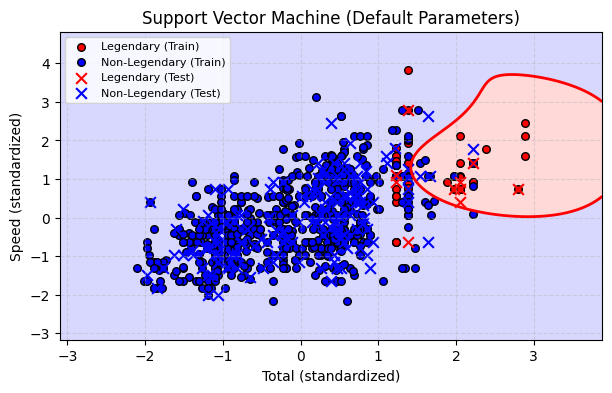

Accuracy (default parameters): 0.95625


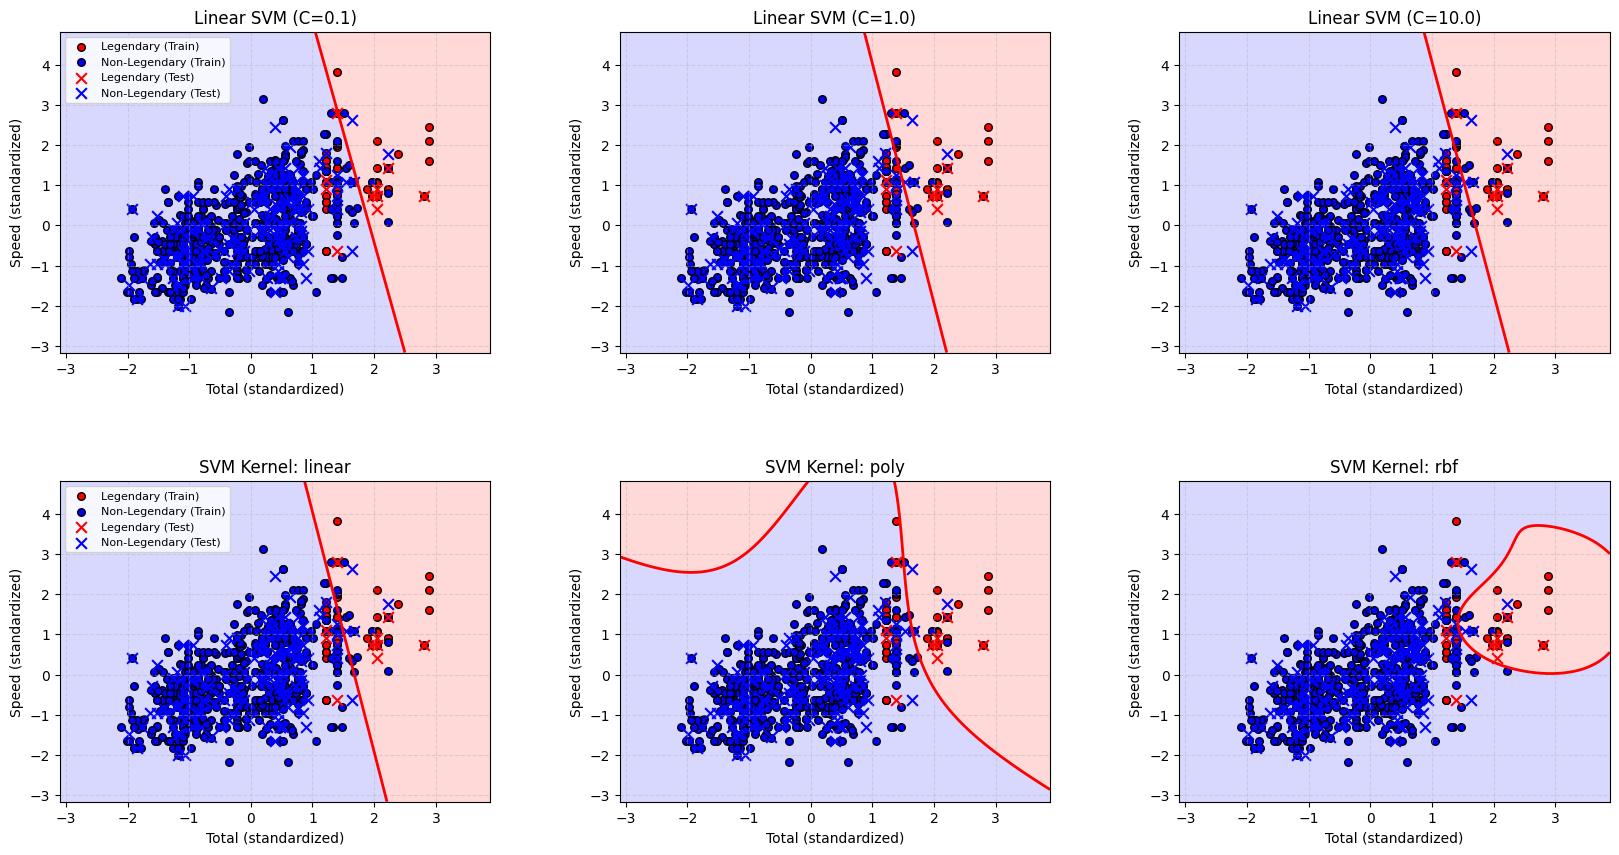


Accuracy for different C values:
   C  Accuracy
 0.1   0.96250
 1.0   0.95625
10.0   0.95625

Accuracy for different kernel types:
Kernel  Accuracy
linear   0.95625
  poly   0.95625
   rbf   0.95625


In [98]:
# -----------------------------------------------------
# Prepare data
# -----------------------------------------------------

X = df[["Total", "Speed"]]
y = df["Legendary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
Xs_tr = scaler.fit_transform(X_train)
Xs_te = scaler.transform(X_test)

# 2D mesh grid
x_min, x_max = Xs_tr[:, 0].min() - 1, Xs_tr[:, 0].max() + 1
y_min, y_max = Xs_tr[:, 1].min() - 1, Xs_tr[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid2d = np.c_[xx.ravel(), yy.ravel()]


# -----------------------------------------------------
# Default SVM Classifier (no parameter tuning)
# -----------------------------------------------------

svm = SVC()
svm.fit(Xs_tr, y_train)
y_pred = svm.predict(Xs_te)
acc = accuracy_score(y_test, y_pred)

# Decision surface
Z = svm.decision_function(grid2d).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(7, 4))
ax.contourf(xx, yy, Z > 0, alpha=0.3, cmap="bwr")
ax.contour(xx, yy, Z, levels=[0], colors="red", linewidths=2)

# Train and test points
ax.scatter(Xs_tr[y_train == 1, 0], Xs_tr[y_train == 1, 1],
           color="red", edgecolor="k", s=30, marker="o", label="Legendary (Train)")
ax.scatter(Xs_tr[y_train == 0, 0], Xs_tr[y_train == 0, 1],
           color="blue", edgecolor="k", s=30, marker="o", label="Non-Legendary (Train)")
ax.scatter(Xs_te[y_test == 1, 0], Xs_te[y_test == 1, 1],
           color="red", s=60, marker="x", label="Legendary (Test)")
ax.scatter(Xs_te[y_test == 0, 0], Xs_te[y_test == 0, 1],
           color="blue", s=60, marker="x", label="Non-Legendary (Test)")

ax.set_title("Support Vector Machine (Default Parameters)")
ax.set_xlabel("Total (standardized)")
ax.set_ylabel("Speed (standardized)")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(loc="upper left", fontsize=8, frameon=True)

plt.show()

print(f"Accuracy (default parameters): {acc:.5f}")


# -----------------------------------------------------
# Test 1: Different C values
# -----------------------------------------------------

C_values = [0.1, 1.0, 10.0]
results_c = []

fig, axes = plt.subplots(2, len(C_values), figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for i, C in enumerate(C_values):
    svm = SVC(kernel="linear", C=C)
    svm.fit(Xs_tr, y_train)
    y_pred = svm.predict(Xs_te)
    acc = accuracy_score(y_test, y_pred)
    results_c.append((C, acc))

    Z = svm.decision_function(grid2d).reshape(xx.shape)

    ax = axes[0, i]
    ax.contourf(xx, yy, Z > 0, alpha=0.3, cmap="bwr")
    ax.contour(xx, yy, Z, levels=[0], colors="red", linewidths=2)

    # Train points
    ax.scatter(Xs_tr[y_train == 1, 0], Xs_tr[y_train == 1, 1],
               color="red", edgecolor="k", s=30, marker="o", label="Legendary (Train)")
    ax.scatter(Xs_tr[y_train == 0, 0], Xs_tr[y_train == 0, 1],
               color="blue", edgecolor="k", s=30, marker="o", label="Non-Legendary (Train)")

    # Test points
    ax.scatter(Xs_te[y_test == 1, 0], Xs_te[y_test == 1, 1],
               color="red", s=60, marker="x", label="Legendary (Test)")
    ax.scatter(Xs_te[y_test == 0, 0], Xs_te[y_test == 0, 1],
               color="blue", s=60, marker="x", label="Non-Legendary (Test)")

    ax.set_title(f"Linear SVM (C={C})")
    ax.set_xlabel("Total (standardized)")
    ax.set_ylabel("Speed (standardized)")
    ax.grid(True, linestyle="--", alpha=0.4)
    if i == 0:
        ax.legend(loc="upper left", fontsize=8, frameon=True)


# -----------------------------------------------------
# Test 2: Different kernel types
# -----------------------------------------------------

kernels = ["linear", "poly", "rbf"]
results_kernel = []

for i, kernel in enumerate(kernels):
    svm = SVC(kernel=kernel, C=1.0)
    svm.fit(Xs_tr, y_train)
    y_pred = svm.predict(Xs_te)
    acc = accuracy_score(y_test, y_pred)
    results_kernel.append((kernel, acc))

    Z = svm.decision_function(grid2d).reshape(xx.shape)

    ax = axes[1, i]
    ax.contourf(xx, yy, Z > 0, alpha=0.3, cmap="bwr")
    ax.contour(xx, yy, Z, levels=[0], colors="red", linewidths=2)

    ax.scatter(Xs_tr[y_train == 1, 0], Xs_tr[y_train == 1, 1],
               color="red", edgecolor="k", s=30, marker="o", label="Legendary (Train)")
    ax.scatter(Xs_tr[y_train == 0, 0], Xs_tr[y_train == 0, 1],
               color="blue", edgecolor="k", s=30, marker="o", label="Non-Legendary (Train)")

    ax.scatter(Xs_te[y_test == 1, 0], Xs_te[y_test == 1, 1],
               color="red", s=60, marker="x", label="Legendary (Test)")
    ax.scatter(Xs_te[y_test == 0, 0], Xs_te[y_test == 0, 1],
               color="blue", s=60, marker="x", label="Non-Legendary (Test)")

    ax.set_title(f"SVM Kernel: {kernel}")
    ax.set_xlabel("Total (standardized)")
    ax.set_ylabel("Speed (standardized)")
    ax.grid(True, linestyle="--", alpha=0.4)
    if i == 0:
        ax.legend(loc="upper left", fontsize=8, frameon=True)

plt.show()


# -----------------------------------------------------
# Accuracy tables
# -----------------------------------------------------

df_results_c = pd.DataFrame(results_c, columns=["C", "Accuracy"])
df_results_kernel = pd.DataFrame(results_kernel, columns=["Kernel", "Accuracy"])

print("\nAccuracy for different C values:")
print(df_results_c.to_string(index=False))
print("\nAccuracy for different kernel types:")
print(df_results_kernel.to_string(index=False))

### Test 1 - Effect of Regularization Parameter `C` on Model Accuracy

In Support Vector Machines, the regularization parameter `C` controls the trade-off between maximizing the decision margin and minimizing classification errors.
- A small `C` enforces strong regularization, allowing more misclassifications but keeping a wider margin, which improves generalization.
- A large `C` weakens regularization, forcing the model to classify training points more strictly and often resulting in a narrower margin that may overfit.

As the regularization parameter `C` increased from `0.1` to `10`, the SVM accuracy remained very stable, varying only slightly between 0.9625 and 0.9563.
With lower `C` (`0.1`), the regularization is stronger, allowing a wider margin and producing a smoother decision boundary that generalizes slightly better.
As `C` increased (`1.0` and `10.0`), the decision boundary became tighter around the training data, but since the dataset is already almost linearly separable, the overall improvement was negligible.
This shows that the model is not highly sensitive to `C`, meaning the data structure is simple enough for a linear margin to perform consistently well.

### Test 2 - Effect of Kernel Type on Model Accuracy

The kernel parameter defines how the SVM transforms input data into a higher-dimensional space to find the optimal separating boundary.
- `linear` uses the raw input space, suitable for linearly separable data.
- `poly` (polynomial) introduces curved boundaries using polynomial combinations of the features.
- `rbf` (radial basis function) maps data into an infinite-dimensional space, allowing highly flexible, non-linear decision surfaces.

Testing different kernel types (`linear`, `poly`, and `rbf`) produced almost identical accuracy values (~0.9563).
This indicates that the relationship between the two features (`Total`, `Speed`) and the target class (`Legendary`) is mostly linear.
The polynomial and RBF kernels introduce non-linear boundaries, but since the data is already well separated by a linear plane, these transformations offer no practical benefit.
In more complex or non-linearly separable datasets, the RBF kernel typically performs better by adapting to curved decision regions, but here all kernels converge to nearly the same separating surface.

## nD Logistic Regression


Accuracy for different C values:
     C  Accuracy
  0.01   0.94375
  0.10   0.95625
  1.00   0.94375
 10.00   0.94375
100.00   0.94375

Accuracy for different penalty types:
   Penalty  Accuracy
        l1   0.94375
        l2   0.94375
elasticnet   0.94375


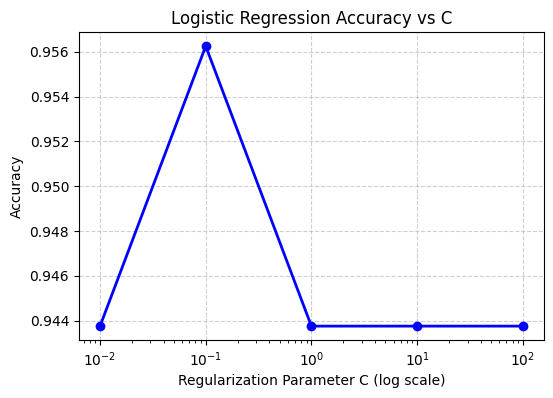

In [99]:
# -----------------------------------------------------
# Prepare data (using multiple features)
# -----------------------------------------------------

X = df[["HP", "Attack", "Defense", "SpAtk", "SpDef", "Speed", "Total"]]
y = df["Legendary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
Xs_tr = scaler.fit_transform(X_train)
Xs_te = scaler.transform(X_test)

# -----------------------------------------------------
# Test 1: Regularization parameter C
# -----------------------------------------------------

C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
results_c = []

for C in C_values:
    logreg = LogisticRegression(C=C, solver="lbfgs", max_iter=5000)
    logreg.fit(Xs_tr, y_train)
    y_pred = logreg.predict(Xs_te)
    acc = accuracy_score(y_test, y_pred)
    results_c.append((C, acc))

# -----------------------------------------------------
# Test 2: Penalty types
# -----------------------------------------------------

penalties = ["l1", "l2", "elasticnet"]
results_penalty = []

for penalty in penalties:
    if penalty == "elasticnet":
        logreg = LogisticRegression(
            penalty="elasticnet", l1_ratio=0.5,
            solver="saga", max_iter=5000
        )
    elif penalty == "l1":
        logreg = LogisticRegression(
            penalty="l1", solver="saga", max_iter=5000
        )
    else:
        logreg = LogisticRegression(
            penalty="l2", solver="lbfgs", max_iter=5000
        )

    logreg.fit(Xs_tr, y_train)
    y_pred = logreg.predict(Xs_te)
    acc = accuracy_score(y_test, y_pred)
    results_penalty.append((penalty, acc))


# -----------------------------------------------------
# Accuracy tables
# -----------------------------------------------------

df_results_c = pd.DataFrame(results_c, columns=["C", "Accuracy"])
df_results_penalty = pd.DataFrame(results_penalty, columns=["Penalty", "Accuracy"])

print("\nAccuracy for different C values:")
print(df_results_c.to_string(index=False))
print("\nAccuracy for different penalty types:")
print(df_results_penalty.to_string(index=False))


# -----------------------------------------------------
# Plot accuracy as function of C
# -----------------------------------------------------

plt.figure(figsize=(6, 4))
plt.plot(df_results_c["C"], df_results_c["Accuracy"], marker="o", color="blue", linewidth=2)
plt.xscale("log")
plt.xlabel("Regularization Parameter C (log scale)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy vs C")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Test 1 – Effect of Regularization Parameter `C` on Model Accuracy

As the regularization parameter `C` increased from `0.01` to `100`, the model’s accuracy remained almost constant, varying slightly between 0.9438 and 0.9563.
At `C = 0.1`, the model achieved its highest accuracy (0.9563), indicating an optimal balance between bias and variance.
For very small `C` (e.g., `0.01`), the strong regularization limited the model’s flexibility, slightly underfitting the data.
When `C` increased (`1.0`, `10.0`, `100.0`), the regularization weakened, allowing the model to fit training data more closely, but since the dataset is already almost linearly separable, the overall effect was negligible.
This demonstrates that the model is robust to different `C` values, and moderate regularization is sufficient to achieve stable generalization.

### Test 2 – Effect of Regularization Type on Model Accuracy
Changing the penalty type between `l1`, `l2`, and `elasticnet` produced identical accuracy values (0.9438).
This consistency suggests that all input features (HP, Attack, Defense, Sp. Atk, Sp. Def, Speed, Total) contribute meaningfully and that the relationship between them and the target (Legendary) is mostly linear.
Since there are no redundant or irrelevant variables, neither sparsity from `l1` nor the mixed penalty from `elasticnet` improves performance.
In higher-dimensional or noisier data, `l1` would typically help by zeroing out weak coefficients, but in this case, the model already generalizes effectively with any penalty type.

### Plot - Accuracy as Function of `C`

The plot shows how accuracy changes with different regularization strengths (`C`) on a logarithmic scale.
Accuracy peaks at `C = 0.1`, where the model reaches 0.956.
This confirms that moderate regularization leads to the best trade-off between bias and variance.
Extremely small or large `C` values reduce performance slightly, showing that both excessive regularization and overfitting can harm generalization.

### Comparison with the 2D Logistic Regression Results
In the 2D case, accuracy and parameter sensitivity were similar.
Adding more features in the nD model did not improve performance, since Total already summarizes most of the others.
The main difference is that the nD model was slightly more stable across `C` and `penalty` changes, showing that extra correlated features smooth parameter effects but add little predictive gain.

## nD SVM Classifier


Accuracy for different C values:
     C  Accuracy
  0.01   0.94375
  0.10   0.95000
  1.00   0.94375
 10.00   0.94375
100.00   0.94375

Accuracy for different kernel types:
Kernel  Accuracy
linear   0.94375
  poly   0.93750
   rbf   0.93125


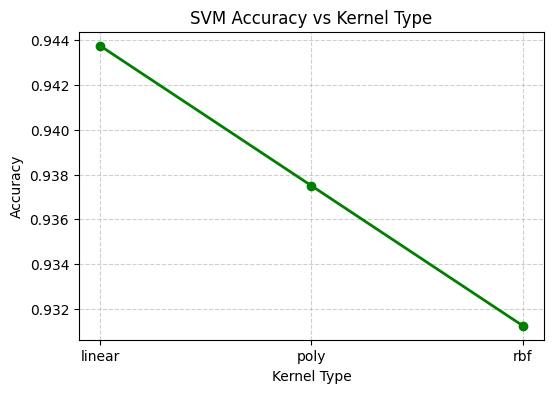

In [100]:
# -----------------------------------------------------
# Prepare data (using multiple features)
# -----------------------------------------------------

X = df[["HP", "Attack", "Defense", "SpAtk", "SpDef", "Speed", "Total"]]
y = df["Legendary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
Xs_tr = scaler.fit_transform(X_train)
Xs_te = scaler.transform(X_test)


# -----------------------------------------------------
# Test 1: Regularization parameter C
# -----------------------------------------------------

C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
results_c = []

for C in C_values:
    svm = SVC(kernel="linear", C=C)
    svm.fit(Xs_tr, y_train)
    y_pred = svm.predict(Xs_te)
    acc = accuracy_score(y_test, y_pred)
    results_c.append((C, acc))


# -----------------------------------------------------
# Test 2: Different kernel types
# -----------------------------------------------------

kernels = ["linear", "poly", "rbf"]
results_kernel = []

for kernel in kernels:
    svm = SVC(kernel=kernel, C=1.0)
    svm.fit(Xs_tr, y_train)
    y_pred = svm.predict(Xs_te)
    acc = accuracy_score(y_test, y_pred)
    results_kernel.append((kernel, acc))


# -----------------------------------------------------
# Accuracy tables
# -----------------------------------------------------

df_results_c = pd.DataFrame(results_c, columns=["C", "Accuracy"])
df_results_kernel = pd.DataFrame(results_kernel, columns=["Kernel", "Accuracy"])

print("\nAccuracy for different C values:")
print(df_results_c.to_string(index=False))
print("\nAccuracy for different kernel types:")
print(df_results_kernel.to_string(index=False))


# -----------------------------------------------------
# Plot accuracy as function of kernel type
# -----------------------------------------------------

plt.figure(figsize=(6, 4))
plt.plot(df_results_kernel["Kernel"], df_results_kernel["Accuracy"], marker="o", color="green", linewidth=2)
plt.xlabel("Kernel Type")
plt.ylabel("Accuracy")
plt.title("SVM Accuracy vs Kernel Type")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Test 1 – Effect of Regularization Parameter `C` on Model Accuracy

As the regularization parameter `C` increased from `0.01` to `100`, the SVM’s accuracy remained stable, ranging narrowly between `0.9438` and `0.9500`.
At `C = 0.1`, the model achieved its highest accuracy (0.9500), suggesting that moderate regularization provides the best balance between margin width and classification precision.
For very small `C` (e.g., `0.01`), the margin was too wide, slightly underfitting the data.
When `C` increased beyond `1.0`, the regularization weakened, the model fitted the training data more tightly, and no further improvements were observed.
This stability indicates that the dataset is mostly linearly separable and not sensitive to small changes in `C`, showing robust generalization.

### Test 2 – Effect of Regularization Type on Model Accuracy

Testing different kernel types (`linear`, `poly`, `rbf`) produced small but consistent differences in accuracy:
linear (0.9438), poly (0.9375), and rbf (0.9313).
The linear kernel slightly outperformed the others, confirming that the relationship between the input features (`HP`, `Attack`, `Defense`, `SpAtk`, `SpDef`, `Speed`, `Total`) and the target variable (`Legendary`) is predominantly linear.
Polynomial and RBF kernels introduce non-linear transformations, but since the data is already nearly linearly separable, those added complexities did not improve performance.
In more complex or non-linear datasets, the `rbf` kernel typically performs better due to its flexibility, but here a linear decision surface suffices.

### Plot - Accuracy as Function of `C`

The plot shows how accuracy changes across different kernels.
The linear kernel yields the best accuracy (0.944), while the RBF kernel slightly decreases to 0.931.
This gradual decline illustrates that non-linear kernels add unnecessary flexibility to a dataset that already has a clear linear boundary, increasing complexity without improving predictive performance.

### Comparison with the 2D SVM Results
In the 2D case, accuracy and parameter effects were nearly identical.
Extending to nD with all features did not meaningfully change results, the data remains linearly separable, and the linear kernel still performs best.
The extra dimensions slightly stabilize accuracy but add no real gain, since `Total` already encodes most of the predictive information from the other stats.

---

# OLD: Mini Project 5: Implement a logistic regression and a linear SVM

---

In [101]:
# -----------------------------------------------------
# Manual Logistic Regression Implementation
# -----------------------------------------------------

class LogisticRegressionManual:
    """
    Manual Logistic Regression implementation using Gradient Descent.
    """

    def sigmoid(self, z):
        """
        The logistic sigmoid function.
        """
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y, lr=0.1, max_iter=5000):
        """
        Train the logistic regression model using Maximum Likelihood Estimation (MLE)
        via Gradient Descent.
        """
        X = np.asarray(X)
        y = np.asarray(y).ravel()
        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.w = np.zeros(n_features)
        self.b = 0.0

        # Gradient Descent (vectorized)
        for i in range(max_iter):
            z = X @ self.w + self.b
            y_pred = self.sigmoid(z)

            # Compute gradients
            dw = (1 / n_samples) * (X.T @ (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Update weights
            self.w -= lr * dw
            self.b -= lr * db

    def predict_proba(self, X):
        """
        Predict probabilities for the positive class.
        """
        X = np.asarray(X)
        z = X @ self.w + self.b
        
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        """
        Predict class labels based on a threshold.
        """
        
        return self.predict_proba(X) >= threshold


# -----------------------------------------------------
# Manual Linear SVM
# -----------------------------------------------------

class LinearSVMManual:
    """
    Manual Linear SVM implementation using Stochastic Gradient Descent.
    """
    
    def fit(self, X, y, C=1.0, max_iter=30):
        """
        Fit the model parameters (w, b). Using Pegasos algorithm.
        """
        X = np.asarray(X, float)
        y = np.where(np.asarray(y).ravel() > 0, 1.0, -1.0) # {-1,+1}
        n, d = X.shape

        # Regularization parameter
        lam = 1.0 / (C * n)
        self.w = np.zeros(d)
        self.b = 0.0
        t = 0

        # Learning rate schedule
        for i in range(max_iter):
            # Update iteration count
            t += 1
            eta = 1.0 / (lam * t)

            # Compute margins
            margin = y * (X @ self.w + self.b)
            mask = margin < 1.0
            
            # Update weights and bias
            if np.any(mask):
                Xm, ym = X[mask], y[mask]
                grad = (Xm.T @ ym) / Xm.shape[0]
                self.w = (1 - eta*lam) * self.w + eta * grad
                self.b = self.b + eta * np.mean(ym)
            else:
                self.w = (1 - eta*lam) * self.w
            
        return self 

    def predict(self, X):
        """
        Predict class labels for the input samples.
        """
        X = np.asarray(X, float)
        
        return (X @ self.w + self.b) >= 0.0


### Test Logistic Regression Implementation vs Scikit-learn Logistic Regression using 1D data

Manual Logistic Regression accuracy: 0.950
Scikit-learn Logistic Regression accuracy: 0.950


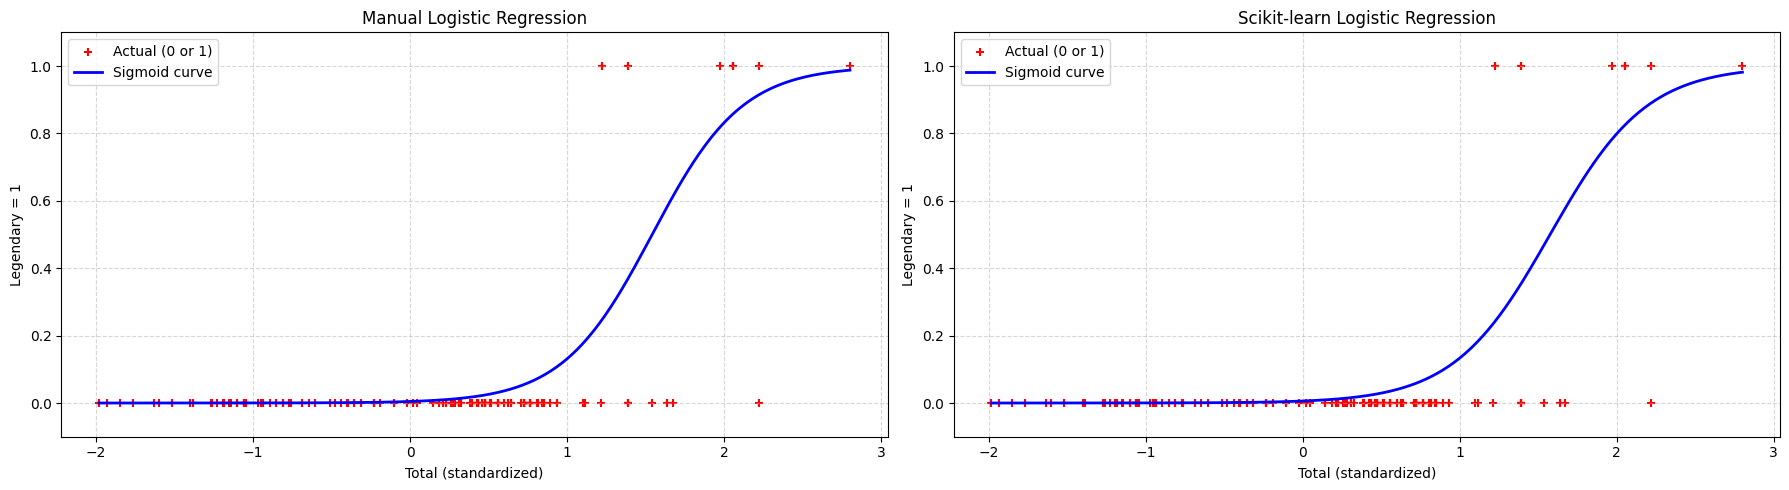

In [102]:
# -----------------------------------------------------
# Prepare data
# -----------------------------------------------------

X = df[["Total"]]
y = df["Legendary"]

# Stratified split to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
Xs_tr = scaler.fit_transform(X_train)
Xs_te = scaler.transform(X_test)


# -----------------------------------------------------
# Train both models
# -----------------------------------------------------

# Manual Logistic Regression
logreg_handy = LogisticRegressionManual()
logreg_handy.fit(Xs_tr, y_train)
y_prob_handy = logreg_handy.predict_proba(Xs_te)
y_pred_handy = (y_prob_handy >= 0.5)

# Scikit-learn Logistic Regression
logreg_sklearn = LogisticRegression()
logreg_sklearn.fit(Xs_tr, y_train)
y_prob_sklearn = logreg_sklearn.predict_proba(Xs_te)[:, 1]
y_pred_sklearn = (y_prob_sklearn >= 0.5)


# -----------------------------------------------------
# Accuracy
# -----------------------------------------------------

acc_handy = accuracy_score(y_test, y_pred_handy)
acc_sklearn = accuracy_score(y_test, y_pred_sklearn)

print(f"Manual Logistic Regression accuracy: {acc_handy:.3f}")
print(f"Scikit-learn Logistic Regression accuracy: {acc_sklearn:.3f}")


# -----------------------------------------------------
# Plot both models
# -----------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
plt.subplots_adjust(wspace=0.3)

# Common x-grid for smooth sigmoid curves
x_grid = np.linspace(Xs_te.min(), Xs_te.max(), 400).reshape(-1, 1)

# Manual Logistic Regression
y_curve_hand = logreg_handy.predict_proba(x_grid)

axes[0].scatter(Xs_te[:, 0], y_test, color="red", marker="+", label="Actual (0 or 1)")
axes[0].plot(x_grid, y_curve_hand, color="blue", linewidth=2, label="Sigmoid curve")
axes[0].set_title("Manual Logistic Regression")
axes[0].set_xlabel(f"Total (standardized)")
axes[0].set_ylabel("Legendary = 1")
axes[0].set_ylim(-0.1, 1.1)
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# Scikit-learn Logistic Regression
y_curve_sklearn = logreg_sklearn.predict_proba(x_grid)[:, 1]

axes[1].scatter(Xs_te[:, 0], y_test, color="red", marker="+", label="Actual (0 or 1)")
axes[1].plot(x_grid, y_curve_sklearn, color="blue", linewidth=2, label="Sigmoid curve")
axes[1].set_title("Scikit-learn Logistic Regression")
axes[1].set_xlabel(f"Total (standardized)")
axes[1].set_ylabel("Legendary = 1")
axes[1].set_ylim(-0.1, 1.1)
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Test Linear SVM Implementation vs Scikit-learn Linear SVM

Sklearn SVM Accuracy: 0.956
Manual SVM Accuracy: 0.956


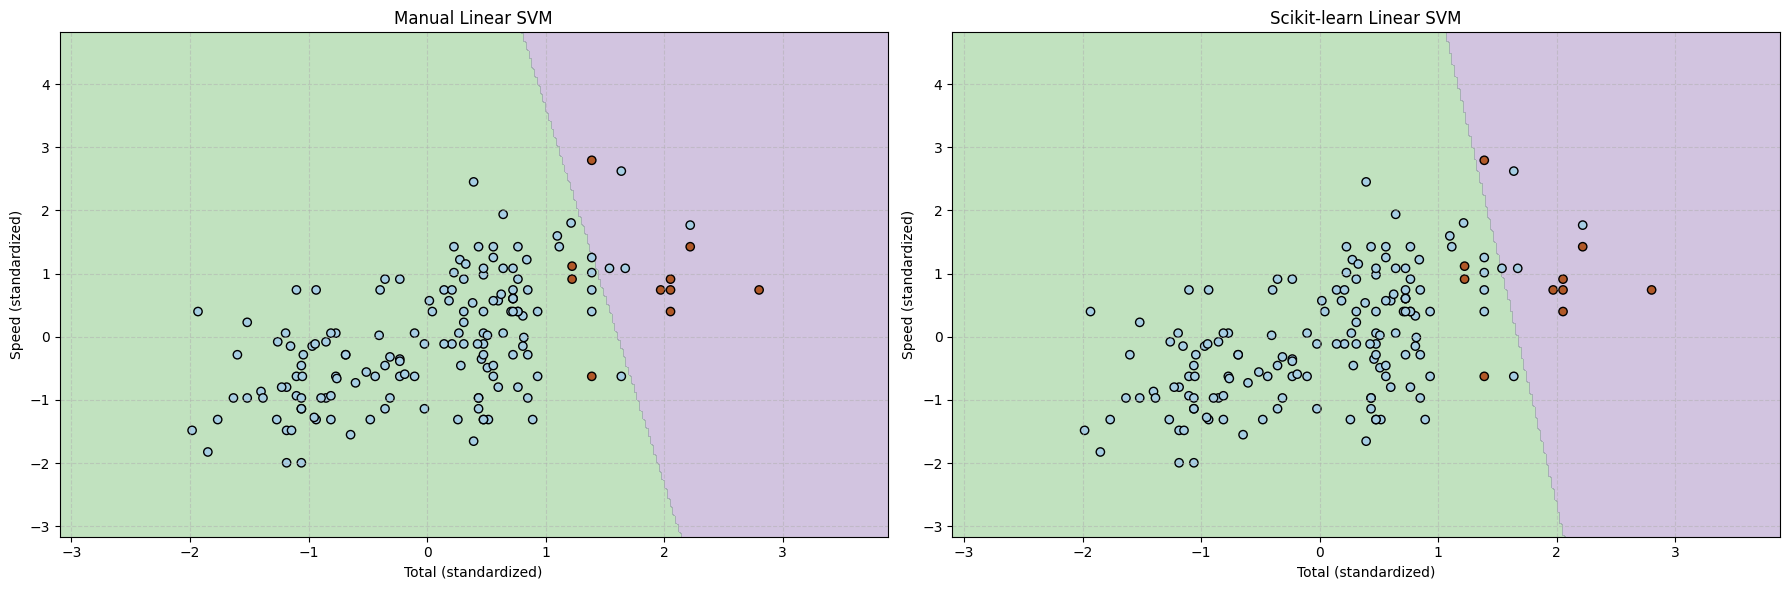

In [103]:
# ------------------------------------------------------
# Prepare data
# ------------------------------------------------------
chosen_features = ["Total", "Speed"]

X = df[chosen_features]
y = df["Legendary"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler()
Xs_tr = scaler.fit_transform(X_train)
Xs_te = scaler.transform(X_test)


# -----------------------------------------------------
# Train both models
# -----------------------------------------------------

# Scikit-learn SVM
svm = LinearSVC()
svm.fit(Xs_tr, y_train)
y_pred_sk = svm.predict(Xs_te)
acc_smv_sk = accuracy_score(y_test, y_pred_sk)
print(f"Sklearn SVM Accuracy: {acc_smv_sk:.3f}")

# Manual SVM
svm_manual = LinearSVMManual()
svm_manual.fit(Xs_tr, y_train)
y_pred_manual = svm_manual.predict(Xs_te)
acc_manual = accuracy_score(y_test, y_pred_manual)
print(f"Manual SVM Accuracy: {acc_manual:.3f}")


# -----------------------------------------------------
# Plot both models
# -----------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)
# Common grid for decision boundary
x_min, x_max = Xs_tr[:, 0].min() - 1, Xs_tr[:, 0].max() + 1
y_min, y_max = Xs_tr[:, 1].min() - 1, Xs_tr[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]

# Manual SVM
Z_manual = svm_manual.predict(grid_points)
Z_manual = Z_manual.reshape(xx.shape)
axes[0].contourf(xx, yy, Z_manual, alpha=0.3, cmap=plt.cm.Paired)
axes[0].scatter(Xs_te[:, 0], Xs_te[:, 1], c=y_test, edgecolors="k", cmap=plt.cm.Paired)
axes[0].set_title("Manual Linear SVM")
axes[0].set_xlabel("Total (standardized)")
axes[0].set_ylabel("Speed (standardized)")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Scikit-learn SVM
Z_sk = svm.predict(grid_points)
Z_sk = Z_sk.reshape(xx.shape)
axes[1].contourf(xx, yy, Z_sk, alpha=0.3, cmap=plt.cm.Paired)
axes[1].scatter(Xs_te[:, 0], Xs_te[:, 1], c=y_test, edgecolors="k", cmap=plt.cm.Paired)
axes[1].set_title("Scikit-learn Linear SVM")
axes[1].set_xlabel("Total (standardized)")
axes[1].set_ylabel("Speed (standardized)")
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()